In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.mixture import GaussianMixture
from random import randint
from sklearn.metrics import confusion_matrix,silhouette_score,calinski_harabasz_score
from sklearn.base import clone
from scipy.spatial.distance import cdist
from itertools import combinations
from r_pca import R_pca
from mpl_toolkits.mplot3d import Axes3D

ImportError: cannot import name 'calinski_harabasz_score'

In [142]:
class DataGenerator:
    
    """
    Parameters
    ----------
    n_samples : int or array-like, optional (default=100)
        If int, it is the total number of points equally divided among
        clusters.
        If array-like, each element of the sequence indicates
        the number of samples per cluster.
    n_features : int, optional (default=3)
        The number of features for each sample.
    centers : int or array of shape [n_centers, n_features], optional
        (default=None)
        The number of centers to generate, or the fixed center locations.
        If n_samples is an int and centers is None, 3 centers are generated.
        If n_samples is array-like, centers must be
        either None or an array of length equal to the length of n_samples.
    cluster_std : float or sequence of floats, optional (default=1.0)
        The standard deviation of the clusters.
    random_state : int, or None (default)
        Determines random number generation for dataset creation

    """    
    
    def __init__(self,method='blobs'):
        self.method=method
            
    def generate(self,n_samples=100, n_features=3, cluster_std=0.5, centers=None,random_state=None,cov=None):

        if self.method=='blobs':   
            data = make_blobs(random_state=random_state,
                n_samples=n_samples, 
                centers=centers, 
                n_features=n_features,
                cluster_std=cluster_std)
        elif self.method=='moons':
            data = make_moons(n_samples=n_samples, shuffle=True, noise=None, random_state=random_state)
       
        if (cov is not None):
                data=(data[0] @ cov,data[1])
                
        return data

    def add_noise(self,X,noise_channels_to_add,noise_level=1):
        
        noise_channels = np.zeros((len(X),noise_channels_to_add))
        X= np.hstack((X,noise_channels))
        
        noise = np.random.uniform(
                low=noise_level*np.max(X), 
                high=noise_level*np.min(X),
                size=X.shape)
        X = X+noise
        return X
    
    def draw_data(self, X, y, title):
        df = pd.DataFrame(X)
        fig = plt.figure()
        if (np.shape(df)[1]==1):
            ax = fig.add_subplot()
            ax.hist(df[0])
            ax.set_title(title)
        elif (np.shape(df)[1]==2):
            ax = fig.add_subplot()
            ax.scatter(df[0],df[1],c=y,edgecolor='k',s=20)
            ax.set_title(title)
        elif (np.shape(df)[1]==3):
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(df[0],df[1],df[2],c=y,edgecolor='k',s=20)
            ax.set_title(title)
        elif (np.shape(df)[1]>3):
            lst_vars=list(combinations(df.columns,2))
            plt.figure(figsize=(20,20))
            for i in range(1,len(lst_vars)+1):
                plt.subplot(10,10,i)
                dim1=lst_vars[i-1][0]
                dim2=lst_vars[i-1][1]
                plt.scatter(df[dim1],df[dim2],c=y,edgecolor='k',s=20)
                plt.xlabel(f"{dim1}",fontsize=10)
                plt.ylabel(f"{dim2}",fontsize=10)
                plt.xlim((-10,10))
                plt.ylim((-10,10))
                plt.title(title)
        

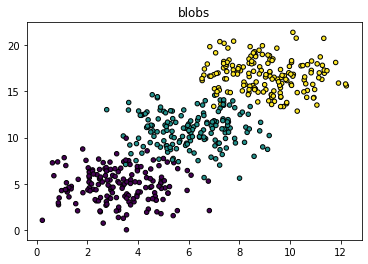

In [194]:
DataGen=DataGenerator(method='blobs')
Data=DataGen.generate(n_samples=500,centers=((1,1),(3,3),(5,5)),random_state=10,cov=np.diag((1.5,3)))
Noisy_Data=DataGen.add_noise(Data[0],1,0.2)
DataGen.draw_data(Noisy_Data[:,0:2],Data[1],'blobs')


In [301]:
class ClusterFinder:

    def __init__(self, method):
        self.method = method
        self.model_score=0
        self.k_val=0
    
    def fit(self,X,n_clusters=3):
        if self.method=='KMeans':
            self.model = KMeans(n_clusters=n_clusters)
        elif self.method=='GMM':
            self.model = GaussianMixture(n_components=n_clusters,covariance_type='full',random_state=None)
        else:
            print('This method is not currently implemented')
        
        self.model.fit(X)
    
    def predict(self,X):
        return self.model.predict(X)
    
    def pca(self,X=None,n_components=None):
        """Robust Principal Components Analysis
        From: http://stackoverflow.com/a/13224592/834250
        Parameters
        ----------
        data : `numpy.ndarray`
            numpy array of data to analyse
        numComponents : `int`
            number of principal components to use

        Returns
        -------
        comps : `numpy.ndarray`
            Principal components
        evals : `numpy.ndarray`
            Eigenvalues
        evecs : `numpy.ndarray`
            Eigenvectors
        """
        RPCA = R_pca(X)
        L, S = RPCA.fit(max_iter=10000, iter_print=10000)
        m, n = L.shape
        L -= L.mean(axis=0)
        R = np.cov(L, rowvar=False)
        # use 'eigh' rather than 'eig' since R is symmetric,
        # the performance gain is substantial
        evals, evecs = np.linalg.eigh(R)
        idx = np.argsort(evals)[::-1]
        evecs = evecs[:,idx]
        evals = evals[idx]
        if n_components is not None:
            evecs = evecs[:, :n_components]
        # carry out the transformation on the data using eigenvectors
        # and return the re-scaled data, eigenvalues, and eigenvectors
        self.evecs = evecs
        return np.dot(evecs.T, L.T).T, evals, evecs
    
    def MSE(self,X,y_pred):
        if self.method=='KMeans':
            centers = self.model.cluster_centers_
        elif self.method=='GMM':
            centers = self.model.means_
        centers = np.dot(centers,self.evecs.T) + X.mean(axis=0)
        centers = [ centers[i] for i in y_pred]
        centers = np.array(centers)
        return np.sum((X-centers)**2)/len(X)
    

iteration: 1, error: 0.028461051555591668
iteration: 2302, error: 4.5915438459792655e-06


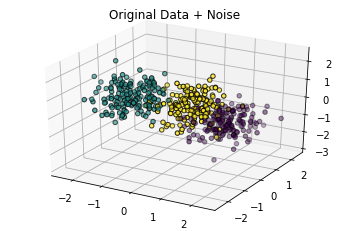

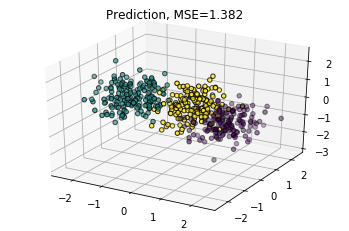

In [314]:
DataGen=DataGenerator(method='blobs')
Data=DataGen.generate(n_samples=500, centers=((1,1,-1),(-1,-1,1),(1,-1,1)))
Noisy = DataGen.add_noise(Data[0],100,0.05)
DataGen.draw_data(Noisy[:,0:3],Data[1],title='Original Data + Noise')
clf = ClusterFinder('KMeans')
PC,evals,evecs = clf.pca(Noisy,n_components=2)
clf.fit(PC,3)
labels=clf.predict(PC)
DataGen.draw_data(Noisy[:,0:3],labels,title='Prediction, MSE='+str(np.round(clf.MSE(Noisy,labels),3)))

iteration: 1, error: 0.1567397652932746
iteration: 4733, error: 4.435661676163937e-06
iteration: 1, error: 0.15127075987172509
iteration: 4896, error: 4.286415926324937e-06
iteration: 1, error: 0.1558882780708748
iteration: 4568, error: 2.432514205822578e-06
iteration: 1, error: 0.1600227690246455
iteration: 3768, error: 3.899223752922932e-06
iteration: 1, error: 0.16859960158277287
iteration: 3707, error: 4.512647068723299e-06
iteration: 1, error: 0.11331720188223583
iteration: 4793, error: 4.203528097243758e-06
iteration: 1, error: 0.13394538123577063
iteration: 5152, error: 4.38414261408281e-06
iteration: 1, error: 0.13823932455246532
iteration: 5365, error: 4.512051872954584e-06
iteration: 1, error: 0.14487750068032387
iteration: 4477, error: 4.7685026651245655e-06
iteration: 1, error: 0.1514932652244438
iteration: 4775, error: 4.999754698342317e-06
iteration: 1, error: 0.05740881837468532
iteration: 1717, error: 4.332673870838962e-06
iteration: 1, error: 0.0971670453966789
iterati

iteration: 3183, error: 4.928526115362501e-06
iteration: 1, error: 0.05566193904347053
iteration: 3545, error: 6.471426365206515e-06
iteration: 1, error: 0.07612577615058998
iteration: 3241, error: 8.891418006018423e-06
iteration: 1, error: 0.08444695739640533
iteration: 2784, error: 9.87213746321982e-06
iteration: 1, error: 0.0044742909685709315
iteration: 2, error: 2.5878465576491913e-07
iteration: 1, error: 0.03322296543920633
iteration: 1602, error: 5.4221572482581675e-06
iteration: 1, error: 0.048677050889141676
iteration: 3, error: 6.738853604669868e-06
iteration: 1, error: 0.06850661888499003
iteration: 3, error: 8.728644029892355e-06
iteration: 1, error: 0.08487178529080044
iteration: 3, error: 1.0462616069514416e-05
iteration: 1, error: 0.1536643261882533
iteration: 4607, error: 3.81594535447472e-06
iteration: 1, error: 0.15462241305173224
iteration: 4353, error: 3.7409707627328926e-06
iteration: 1, error: 0.15714295298482478
iteration: 3826, error: 4.054313724937667e-06
itera

iteration: 2639, error: 4.466821728555971e-06
iteration: 1, error: 0.08296448875398482
iteration: 3508, error: 4.8084109670545405e-06
iteration: 1, error: 0.09530071009256004
iteration: 3935, error: 5.541150764909121e-06
iteration: 1, error: 0.10847139437085826
iteration: 4845, error: 6.3310410875073716e-06
iteration: 1, error: 0.01574890021104963
iteration: 2, error: 3.618087037126625e-06
iteration: 1, error: 0.05583949910898991
iteration: 4167, error: 4.667569882848008e-06
iteration: 1, error: 0.06581836670224442
iteration: 4155, error: 5.587920258298313e-06
iteration: 1, error: 0.08290958107835851
iteration: 4279, error: 7.021367489005134e-06
iteration: 1, error: 0.0940211241290088
iteration: 4422, error: 8.03169978441372e-06
iteration: 1, error: 0.008619305358857125
iteration: 2, error: 9.658784085356206e-07
iteration: 1, error: 0.04210184621735659
iteration: 2912, error: 4.9142572175051025e-06
iteration: 1, error: 0.05322965524718673
iteration: 3476, error: 6.196288676022799e-06
i

iteration: 6091, error: 4.344597808579714e-06
iteration: 1, error: 0.137063777372864
iteration: 5291, error: 4.4834345319097305e-06
iteration: 1, error: 0.1433612124269468
iteration: 3595, error: 4.712480525937968e-06
iteration: 1, error: 0.15493070069431747
iteration: 4351, error: 5.1554372613866665e-06
iteration: 1, error: 0.05738418596441807
iteration: 2283, error: 4.353763914358533e-06
iteration: 1, error: 0.09810992704241864
iteration: 3130, error: 4.42830520091699e-06
iteration: 1, error: 0.10366378917168764
iteration: 3174, error: 4.71891059964105e-06
iteration: 1, error: 0.11242195653907455
iteration: 4272, error: 5.1612531679379036e-06
iteration: 1, error: 0.12114305423046441
iteration: 4551, error: 5.54247820391028e-06
iteration: 1, error: 0.03572019295685544
iteration: 1838, error: 4.146674969484743e-06
iteration: 1, error: 0.07652313703288723
iteration: 2428, error: 4.378456546411899e-06
iteration: 1, error: 0.08577555679263062
iteration: 3410, error: 4.968515982885203e-06


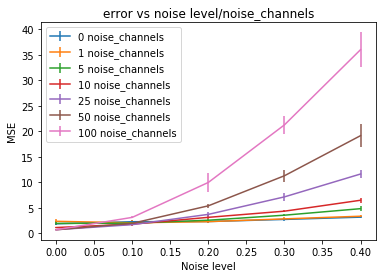

In [315]:
DataGen=DataGenerator(method='blobs')
res = []
iter = 10
for i in np.arange(0,iter):
    for noise_chan in (0,1,5,10,25,50,100):
        for noise_level in (0,0.1,0.2,0.3,0.4):
            Data=DataGen.generate(n_samples=500, centers=((1,1,-1),(-1,-1,1),(1,-1,1)))
            Noisy = DataGen.add_noise(Data[0],noise_chan,noise_level)
            clf = ClusterFinder('GMM')
            PC,evals,evecs = clf.pca(Noisy,n_components=2)
            clf.fit(PC,3)
            labels=clf.predict(PC)
            MSE = clf.MSE(Noisy,labels)
            res.append(np.array([noise_chan,noise_level,MSE]))

df = pd.DataFrame(list(map(np.ravel, res)),columns=['noise_channels', 'noise_level', 'MSE'])

for noise_channels in (0,1,5,10,25,50,100):
    group = df[df.noise_channels==noise_channels].groupby(['noise_level'])
    means = group.mean()
    stds = group.std()
    plt.errorbar(list(means.index),list(means.MSE),list(stds.MSE),label=str(noise_channels)+' noise_channels')
    
plt.ylabel("MSE")
plt.xlabel("Noise level")
plt.title("error vs noise level/noise_channels")
plt.legend(loc='upper left')

